In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import altair as alt
%matplotlib inline

In [2]:
pd.options.display.max_columns = 999

In [3]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 9B: OpenStreetMap, Urban Networks, and Interactive Web Maps
Oct 29, 2020

<img src="https://media.giphy.com/media/3oriNYMXEh2K5l4D9C/giphy.gif"></img>

## Important: Update your local environment

- Small update to course's Python environment relevant to today's lecture
- Update the environment on your laptop using [these instructions](https://musa-550-fall-2020.github.io/guides/conda#updating-an-existing-environment) on course website

## The final project

https://github.com/MUSA-550-Fall-2020/final-project

## This week: OpenStreetMap (OSM)

Three parts:
- **OSMnx:** downloading and manipulating streets as networks
- **Pandana:** networks focused on accessibility of amenities, e.g., walking distances to the nearest amenities
- **Related:** interactive web maps in Python



In [4]:
import osmnx as ox

Make sure the version >= 0.16 for this notebook to work!

In [5]:
print(ox.__version__)

0.16.1


## Part 3: Interactive maps in Python

Haven't we already done this?

## Yes!

We've used hvplot, holoviews, datashader, etc. to create interactive map-based visualizations

## Why do we need something more?

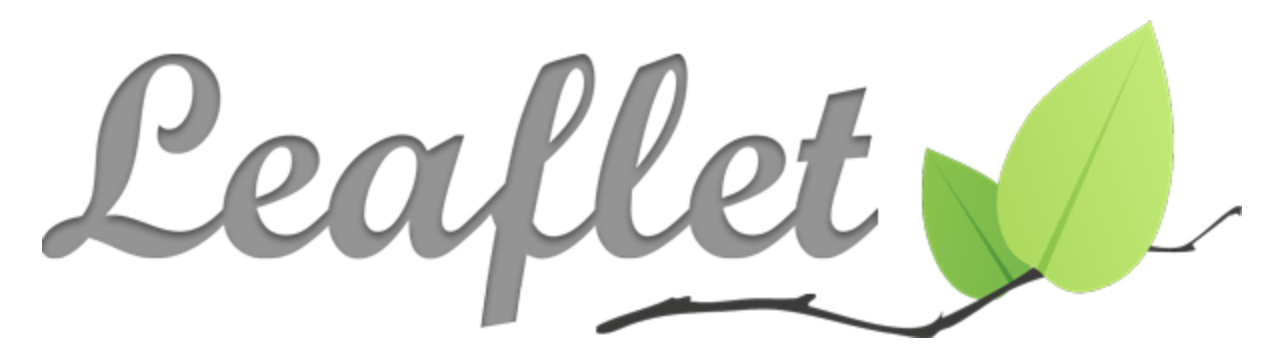</img>

## The benefits of Leaflet

- The leading open-source mapping library
- Simple and powerful
- Leverage the open-source community and lots of powerful plugins

## Folium: Leaflet in Python

**Pros**
- Create Leaflet.js maps directly from Python
- Combine power of Leaflet.js with the data wrangling ease of Python

**Cons**
- A wrapper for **most, but not all** of Leaflet's functionality
- Can be difficult to debug and find errors

## Revisiting routing with OSMnx

OSMnx leverages Folium under the hood to make interactive graphs of street networks!

**Key function:** `ox.plot_graph_folium` will make an interactive map of the graph object

Load the street network around City Hall

In [6]:
G = ox.graph_from_address('City Hall, Philadelphia, USA', 
                          dist=1500, 
                          network_type='drive')

In [7]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, 
                                 popup_attribute='name', 
                                 edge_width=2)

In [8]:
ox.plot_graph_folium?

And now save the map object and load it into the Jupyter notebook

In [9]:
from IPython.display import IFrame # loads HTML files

In [10]:
filepath = 'graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

### Note

Folium map objects are *supposed* to render automatically in the Jupyter notebook, so if you output a Folium map from a notebook cell, it will render. 

However, there a lot of times when the map won't show up properly, especially if the map has a large amount of data. Saving the file locally and loading it to the notebook via an IFrame will always work.

In [11]:
type(graph_map)

folium.folium.Map

In [12]:
graph_map

## Exercise: shortest route between the Liberty Bell and Art Museum

Let's calculate the shortest route between [the Art Museum](https://www.openstreetmap.org/way/28533972) and the [Liberty Bell](https://www.openstreetmap.org/node/1207480649).

See last lecture (Lecture 9A) for a guide!

### Step 1: Download amenity info from OSM using OSMnx

Use OSMnx to download all amenities in Philadelphia of type "tourism".

- The `ox.geometries_from_place()` can download OSM features with a specific tag
- Consult the OSM pages ([the Art Museum](https://www.openstreetmap.org/way/28533972) and [Liberty Bell](https://www.openstreetmap.org/node/1207480649)) for each feature for additional info
- Both features are categorized as "tourism" in the OSM data — use the "tags" keyword to select this category

### Step 2: Identify the Art Museum and Liberty Bell geometries

You should notice we have the building footprint for the Art Museum (a polygon geometry) and the point location for the Liberty Bell.

- The names of the features are "Philadelphia Museum of Art" and "Liberty Bell" — you can identify these names using the OSM website
- The `.squeeze()` function can be useful for converting to a Series object from a DataFrame of length 1

### Step 3: Extract the lat and lng coordinates

For the Art Museum geometry, we can use the `.geometry.centroid` attribute to calculate the centroid of the building footprint. 

**Remember:** we need the coordinates in the order of (latitude, longitude)

### Step 4: Find the nearest nodes on our OSMnx graph

Use the street network graph around City Hall and the `ox.get_nearest_node()` function to find the starting and ending nodes for the trip.

### Step 5: Use `networkx` to find the shortest path between nodes

The `nx.shortest_path()` will do the calculation for you!

In [20]:
import networkx as nx

## Example: interactive maps of network routes

Now, we can overlay the shortest route between two nodes on the folium map.

**Key function**: use `ox.plot_route_folium` to plot the route.

In [22]:
# plot the route with folium
route_map = ox.plot_route_folium(G, route)

In [23]:
filepath = 'route.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=500)

We can also add the underlying street network graph

In [24]:
# plot the route with folium on top of the previously created graph_map
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map)

In [25]:
# save as html file then display map as an iframe
filepath = 'route_graph.html'
route_graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

Note the `Leaflet` annotation in the bottom right corner of the maps...

## Getting started with Folium

**Things we'll cover:**
1. Creating a base map with tiles
1. Overlaying GeoJSON polygons
1. Plotting an interactive choropleth

In [26]:
import folium

## 3.1 Creating a Folium map

**Key function:** `folium.Map`

### Lots of configuration options

Some key ones: 
- **location**: the center location of the map
- **zoom_start**: the initial zoom level of the map
- **tiles**: the name of the tile provider 

Let's take a look at the help message:

In [27]:
folium.Map?

### The default tiles: OpenStreetMap

In [28]:
# let's center the map on Philadelphia
m = folium.Map(
    location=[39.99, -75.13],
    zoom_start=11
)

m

In [29]:
m = folium.Map(
    location=[39.99, -75.13],
    zoom_start=11,
     tiles='stamenwatercolor'
)

m

### Using custom tile sets

- Many sites provide free tile sets for download
- Just need the URL of the tile server
- Very useful demo of tile providers: https://leaflet-extras.github.io/leaflet-providers/preview

Let's try out the ESRI World Map:

**Important: for custom tile providers, you need to specify the attribution too!** 

In [30]:
tile_url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Source: Esri, DeLorme, NAVTEQ, USGS, Intermap, iPC, NRCAN, Esri Japan, METI, Esri China (Hong Kong), Esri (Thailand), TomTom, 2012'

In [31]:
m = folium.Map(
    location=[39.99, -75.13],
    zoom_start=11,
    tiles=tile_url,
    attr=attr
)

m

## 3.2 Overlaying GeoJSON on a folium map

**Key function:** `folium.GeoJson`

**Key parameters:**
- `style_function`: set the default style of the features
- `highlight_function`: set the style when the mouse hovers over the features 
- `tooltip`: add a tooltip when hovering over a feature

In [32]:
folium.GeoJson?

In [33]:
folium.GeoJsonTooltip?

### Example: Philadelphia ZIP codes & Neighborhoods

In [34]:
# Load neighborhoods from GitHub
url = "https://github.com/azavea/geo-data/raw/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"
hoods = gpd.read_file(url).rename(columns={"mapname": "neighborhood"})

In [35]:
# Load ZIP codes from Open Data Philly
zip_url = "http://data.phl.opendata.arcgis.com/datasets/b54ec5210cee41c3a884c9086f7af1be_0.geojson"
zip_codes = gpd.read_file(zip_url).rename(columns={"CODE":"ZIP Code"})

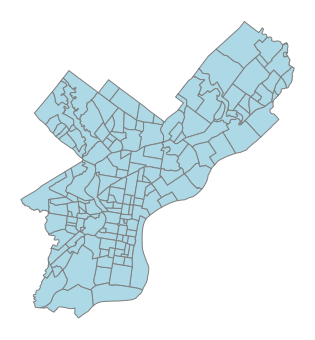

In [36]:
ax = ox.project_gdf(hoods).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

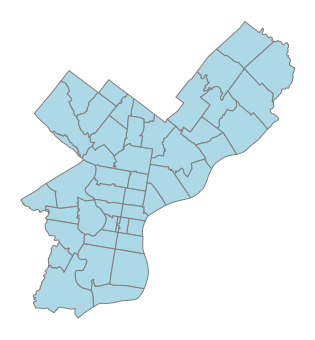

In [37]:
ax = ox.project_gdf(zip_codes).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

Define functions to set the styles:

In [38]:
def get_zip_code_style(feature):
    """Return a style dict."""
    return {"weight": 2, "color": "white"}


def get_neighborhood_style(feature):
    """Return a style dict."""
    return {"weight": 2, "color": "lightblue", "fillOpacity": 0.1}


def get_highlighted_style(feature):
    """Return a style dict when highlighting a feature."""
    return {"weight": 2, "color": "red"}

### Usual Leaflet/Folium syntax

1. Create the map
2. Create your overlay layer
3. Add your overlay layer to your map

In [39]:
# Create the map
m = folium.Map(
    location=[39.99, -75.13],
    tiles='Cartodb dark_matter',
    zoom_start=11
)

# Add the ZIP Codes GeoJson to the map
folium.GeoJson(
    zip_codes.to_crs(epsg=4326).to_json(), # IMPORTANT: make sure CRS is lat/lng (EPSG=4326)
    name='Philadelphia ZIP_codes',
    style_function=get_zip_code_style,
    highlight_function=get_highlighted_style,
    tooltip=folium.GeoJsonTooltip(['ZIP Code'])
).add_to(m)


# Add a SECOND layer for neighborhoods
folium.GeoJson(
    hoods.to_crs(epsg=4326).to_json(), # IMPORTANT: make sure CRS is lat/lng (EPSG=4326)
    name='Neighborhoods',
    style_function=get_neighborhood_style,
    tooltip=folium.GeoJsonTooltip(['neighborhood'])
).add_to(m)


# Also add option to toggle layers
folium.LayerControl().add_to(m)

m

## Important notes:

- The data should be passed as GeoJSON rather than a GeoDataFrame — you need to call `.to_json()`
- I've added a `LayerControl` to toggle different layers on the map
- I've specified a tooltip using `folium.GeoJsonTooltip`

## 3.3 Plotting a choropleth map

Overlay GeoJSON features on an interactive map, colored by a specific data variable

## At-home exercise: load data for internet availability in US counties

In the interest of time, I've used `cenpy` to download data for internet availability from the 2018 5-year ACS, but a good at-home exercise is to try to replicate my work. 

- The relevant data table is [B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD](https://data.census.gov/cedsci/table?q=B28002&tid=ACSDT5Y2018.B28002&hidePreview=false)
- Columns: 
    - B28002_001E: the total universe of households
    - B28002_013E: households without internet

In [51]:
census_data = pd.read_csv("./data/internet_avail_census.csv", dtype={"geoid": str})

In [52]:
# Remove counties with no households
valid = census_data['universe'] > 0
census_data = census_data.loc[valid]

# Calculate the percent without internet
census_data['percent_no_internet'] = census_data['no_internet'] / census_data['universe']

Load counties from the data folder as well:

In [53]:
counties = gpd.read_file("./data/us-counties-10m.geojson")

## Now let's make the choropleth..

## The easy way: use folium.Choropleth

- **The good:** 
    - Automatically generate a choropleth from a set of features and corresponding pandas DataFrame
    - Automatic creation of a legend
- **The bad:** 
    - no tooltip and little highlight interactivity (currently being worked on)

In [54]:
folium.Choropleth?

Steps:

1. Pass the geometry data (counties) as GeoJSON **in lat/lng CRS**
1. Pass in the census data separately
1. Pas in the column that we match the geometries on (`key_on=`), using the GeoJSON "features.properties." syntax
1. Pass the data *key* (column to match the data on) and the data *value* (the column to color the geometries by) via the `columns=` keyword

In [55]:
m = folium.Map(location=[40, -98], zoom_start=4)

# Convert the counties geometries into GeoJSON
counties_geojson = counties.to_crs(epsg=4326).to_json()

folium.Choropleth(
    geo_data=counties_geojson, # Pass in GeoJSON data for counties
    name='choropleth',
    data=census_data, # the census data
    columns=["geoid", 'percent_no_internet'], # First column must be the key, second the values
    key_on="feature.properties.id", # Key to match on in the geometries
    fill_color='RdPu', # any ColorBrewer name will work here
    fill_opacity=0.7,
    line_opacity=1,
    line_weight=0.5,
    legend_name='Households without Internet (%)'
).add_to(m)


m

## The hard way: use folium.GeoJson

- **The good:**
    - more customizable, and can add user interaction
- **The bad:**
    - requires more work
    - no way to add a legend, see [this open issue on GitHub](https://github.com/python-visualization/folium/issues/528)

## The steps involved

1. Join data and features
1. Define a function to style features based on data values
1. Create GeoJSON layer and add it to the map

### Step 1: Join the census data and features

In [56]:
census_joined = pd.merge(
    counties[["id", "geometry"]], census_data, left_on="id", right_on="geoid"
)

In [57]:
census_joined.head()

id                                           geometry  \
0  53073  MULTIPOLYGON (((-120.85361 49.00011, -120.7674...   
1  30105  POLYGON ((-106.11238 48.99904, -106.15187 48.8...   
2  30029  POLYGON ((-114.06985 48.99904, -114.05908 48.8...   
3  16021  POLYGON ((-116.04755 49.00065, -116.04755 48.5...   
4  30071  POLYGON ((-107.17840 49.00011, -107.20712 48.9...   

                         NAME  universe  no_internet  state  county  geoid  \
0  Whatcom County, Washington   85008.0       9189.0     53      73  53073   
1      Valley County, Montana    3436.0        672.0     30     105  30105   
2    Flathead County, Montana   38252.0       5662.0     30      29  30029   
3      Boundary County, Idaho    4605.0       1004.0     16      21  16021   
4    Phillips County, Montana    1770.0        484.0     30      71  30071   

   percent_no_internet  
0             0.108096  
1             0.195576  
2             0.148018  
3             0.218024  
4             0.273446

### Step 2: Normalize the data column to 0 to 1

We will use a matplotlib colorbar and it requires data to be between 0 and 1

In [58]:
x = census_joined['percent_no_internet']
census_joined['percent_no_internet_normalized'] = (x - x.min()) / (x.max() - x.min())

### Step 3: Define a style function

- create a matplotlib colorbar
- based on the feature data, evaluate the colorbar and convert to a hex string

In [59]:
import matplotlib.colors as mcolors

In [60]:
# use a red-purple colorbrewer color scheme
cmap = plt.get_cmap('RdPu')

In [61]:
cmap(0.5)

(0.9670280661284122, 0.40464436755094196, 0.6307574009996155, 1.0)

In [62]:
mcolors.rgb2hex(cmap(0))

'#fff7f3'

In [63]:
mcolors.rgb2hex(cmap(1.0))

'#49006a'

In [64]:
def get_style(feature):
    # get the data value from the feature
    value = feature['properties']['percent_no_internet_normalized']
    
    # evaluate the color map
    # NOTE: value must between 0 and 1
    rgb_color = cmap(value) # this is a RGB tuple
    
    # convert to hex string
    color = mcolors.rgb2hex(rgb_color)
    
    # return the style dictionary
    return {'weight': 0.25, 'color': color, 'fillColor': color, "fillOpacity": 0.75}

### Step 4: Convert our data to GeoJSON

**Be sure to only keep the data columns we'll actually use!**

In [65]:
needed_cols = ['NAME', 'percent_no_internet', 'percent_no_internet_normalized', 'geometry']
census_json = census_joined[needed_cols].to_json()

In [66]:
# initialize the map
m = folium.Map(location=[40, -98], zoom_start=4)

# add the GeoJson to the map
folium.GeoJson(
    census_json,
    name='choropleth',
    style_function=get_style,
    highlight_function=get_highlighted_style,
    tooltip=folium.GeoJsonTooltip(['NAME', 'percent_no_internet'])
).add_to(m)


folium.LayerControl().add_to(m)

# avoid a rendering bug by saving as HTML and re-loading
m.save('percent_no_internet.html')

## And viola! 

The hard way is **harder**, but we have a tooltip and highlight interactivity!

In [67]:
IFrame('percent_no_internet.html', width=800, height=500)

## Exercise: Can we repeat this with altair?

Try to replicate the above interactive map exactly (minus the background tiles). This includes:

- Using the blue purple colorbrewer scheme
- Having a tooltip with the percentage and county name

Altair's syntax is similar to the folium.Choropleth syntax — you should pass the counties GeoDataFrame to the `alt.Chart()` and then use the `transform_lookup()` to merge those geometries to the census data and pull in the census data column we need ("percent_without_internet").

**Hints**
- The altair example gallery includes a good choropleth example: https://altair-viz.github.io/gallery/choropleth.html
- See [altair documentation](https://altair-viz.github.io/user_guide/customization.html#color-schemes) on changing the color scheme and the [Vega documentation](https://vega.github.io/vega/docs/schemes/#reference) for the names of the allowed color schemes in altair
- You'll want to specify the projection type as "albersUsa" 

In [68]:
import altair as alt

## Leaflet/Folium plugins

One of leaflet's strengths: a rich set of open-source plugins

https://leafletjs.com/plugins.html

Many of these are available in Folium!

## Example: Heatmap

In [70]:
from folium.plugins import HeatMap

In [71]:
HeatMap?

## Exercise: Plot a heatmap of shooting data in Philadelphia in the last 90 days

- Data available from OpenDataPhilly: https://www.opendataphilly.org/dataset/shooting-victims
- Query the database API directly to get the GeoJSON
- We can use the `carto2gpd` package to get the data
- API documentation: https://cityofphiladelphia.github.io/carto-api-explorer/#shootings

### Step 1: Download the data from CARTO

You can use the "current_date" variable (built in to the SQL database) to get the current date

For example, to get the shootings from the past 7 days, we could do:

``SELECT * FROM shootings WHERE date_ >= current_date - 7``

In [72]:
import carto2gpd

### Step 2: Remove missing geometries

Some shooting incidents don't have locations — use the `.geometry.notnull()` function to trim the data frame to those incidents with valid geometries.

### Step 3: Extract out the lat/lng coordinates

**Note:** We need an array of (latitude, longitude) pairs. Be careful about the order!

### Step 4: Make a Folium map and add a HeatMap

The HeatMap takes the list of coordinates (first column lat and second column lng)

## That's it!


- Next week: clustering and the start of machine learning
- Pre-recorded lecture will be posted on Sunday/Monday
- HW #5 (optional) due a week from today
- See you next Thursday!